# Introduction

Readers can use this notebook to simulate the sampling process with 

**gumbel-max** (indexed from TiTok and MaskGIT code) and 

**multinomial** methods (ours).

*Note that the rendering of matplotlib cannot display very narrow bars, so we choose 8192 as the max category number for best visualization.*


## Gumbel-max sampling
the *G(t)* we discussed in the paper refers to **temp** in

np.argmax(logits + **temp** * gumbel_noise)

MVTM methods have made this a heavily tuned heuristics for relative large vocabulary tokenizers.


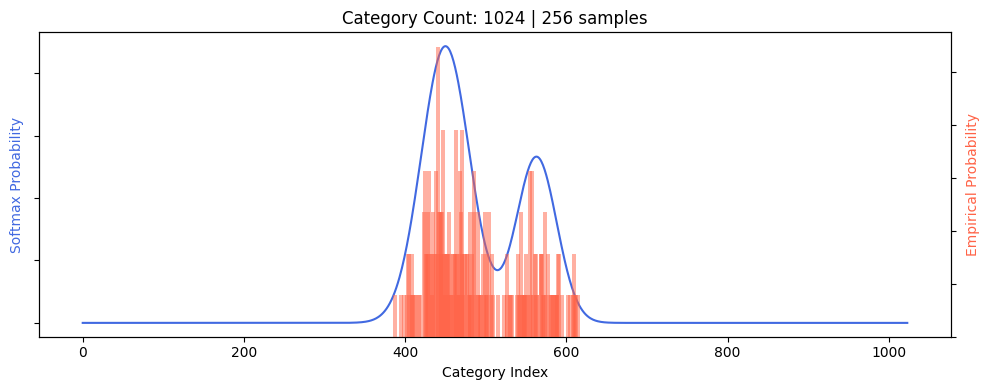

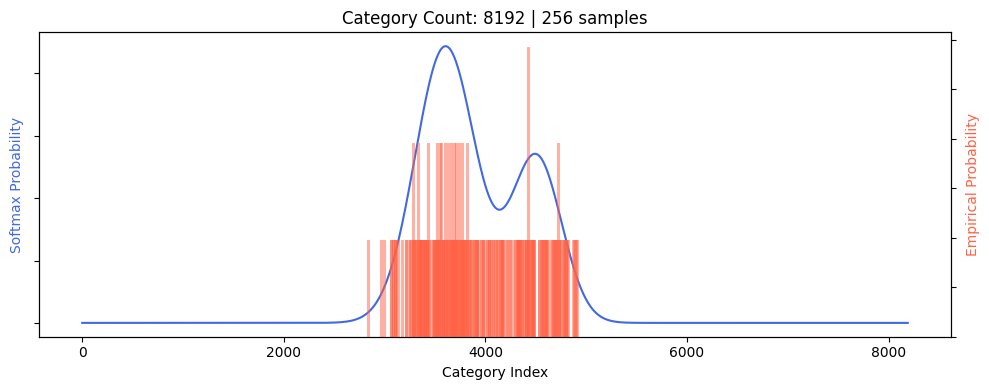

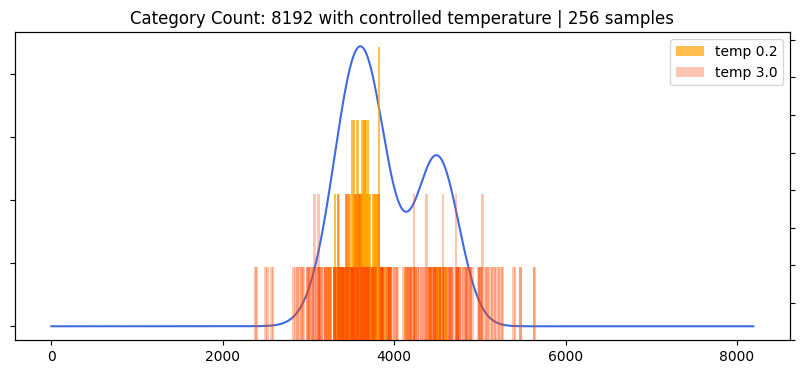

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

def gumbel_max_sample(logits, num_samples, temp=1.0):
    samples = []
    for _ in range(num_samples):
        gumbel_noise = -np.log(-np.log(np.random.uniform(0, 1, size=logits.shape)))
        sampled_index = np.argmax(logits + temp * gumbel_noise)
        samples.append(sampled_index)
    return np.array(samples)

def simulate_dual_gaussian_logits(num_classes, 
                                    mean1_ratio=0.44,  
                                    mean2_ratio=0.55, std_dev=10.0):
    """
    Create logits as the sum of two Gaussian bumps.
    
    mean1_ratio and mean2_ratio are relative positions in [0, 1]
    std1 and std2 are standard deviations for the two Gaussians
    """

    std1 = 6 * std_dev
    std2 = 5 * std_dev
    indices = np.arange(num_classes)
    mean1 = int(num_classes * mean1_ratio)
    mean2 = int(num_classes * mean2_ratio)

    gaussian1 = np.exp(-((indices - mean1) ** 2) / (2 * std1 ** 2))
    gaussian2 = np.exp(-((indices - mean2) ** 2) / (2 * std2 ** 2))

    logits = np.log(1.5 * gaussian1 + 0.9 * gaussian2)

    return logits


def simulate_and_plot_dual_gaussian_dual_axis(num_classes, num_samples, std_dev=100.0, width=5, temp=1.0):
    logits = simulate_dual_gaussian_logits(num_classes, std_dev=std_dev)
    softmax_probs = np.exp(logits) / np.sum(np.exp(logits))

    samples = gumbel_max_sample(logits, num_samples, temp=temp)
    counts = np.bincount(samples, minlength=num_classes)
    empirical_probs = counts / num_samples

    c1 = 'royalblue'
    c2 = 'tomato'

    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax2 = ax1.twinx()
    ax1.plot(softmax_probs, color=c1, label="Softmax Probabilities")
    ax2.bar(np.arange(num_classes), empirical_probs, alpha=0.5, width=width, color=c2, label="Empirical")

    # print(empirical_probs.max())

    ax1.set_xlabel("Category Index")
    ax1.set_ylabel("Softmax Probability", color=c1)
    ax2.set_ylabel("Empirical Probability", color=c2)

    ax1.axes.yaxis.set_ticklabels([])
    # ax2.axes.xaxis.set_ticklabels([])
    ax2.axes.yaxis.set_ticklabels([])

    plt.title(f"Category Count: {num_classes} | {num_samples} samples")

    ax1.tick_params(axis='y', labelcolor=c1)
    ax2.tick_params(axis='y', labelcolor=c2)

    fig.tight_layout()
    plt.show()


def simulate_and_plot_dual_gaussian_dual_axis_2in1(num_classes, num_samples, std_dev=100.0, width=5, temp=1.0):
    logits = simulate_dual_gaussian_logits(num_classes, std_dev=std_dev)
    softmax_probs = np.exp(logits) / np.sum(np.exp(logits))

    samples_1 = gumbel_max_sample(logits, num_samples, temp=3.0)
    samples_2 = gumbel_max_sample(logits, num_samples, temp=0.2)
    counts_1 = np.bincount(samples_1, minlength=num_classes)
    counts_2 = np.bincount(samples_2, minlength=num_classes)
    empirical_probs_1 = counts_1 / num_samples
    empirical_probs_2 = counts_2 / num_samples

    c1 = 'royalblue'
    c2 = 'orangered'
    c3 = 'orange'

    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax2 = ax1.twinx()
    # ax3 = ax1.twinx()
    ax1.plot(softmax_probs, color=c1, label="Softmax Probabilities")
    ax2.bar(np.arange(num_classes), empirical_probs_2, alpha=0.7, width=width, color=c3, label="temp 0.2")
    ax2.bar(np.arange(num_classes), empirical_probs_1, alpha=0.3, width=width, color=c2, label="temp 3.0")

    ax1.axes.yaxis.set_ticklabels([])
    # ax2.axes.xaxis.set_ticklabels([])
    ax2.axes.yaxis.set_ticklabels([])

    plt.title(f"Category Count: {num_classes} with controlled temperature | {num_samples} samples")
    plt.legend()
    plt.show()
# Example runs
simulate_and_plot_dual_gaussian_dual_axis(num_classes=1024, num_samples=256, std_dev=5.0)
simulate_and_plot_dual_gaussian_dual_axis(num_classes=8192, num_samples=256, std_dev=50.0, width=30)
simulate_and_plot_dual_gaussian_dual_axis_2in1(num_classes=8192, num_samples=256, std_dev=50.0, width=30)



## Multinomial sampling.


*We use numpy for quick demonstration on any portable device. In real implementations, torch.multinomial() is used.*

0.01171875


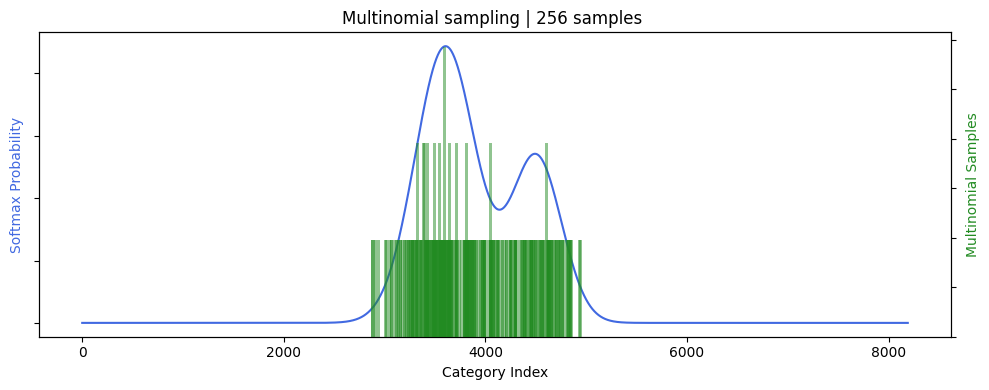

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

def gumbel_max_sample(logits, num_samples, temp=1.0):
    samples = []
    for _ in range(num_samples):
        gumbel_noise = -np.log(-np.log(np.random.uniform(0, 1, size=logits.shape)))
        sampled_index = np.argmax(logits + temp * gumbel_noise)
        samples.append(sampled_index)
    return np.array(samples)

def numpy_multinomial_sample(logits, num_samples):
    probs = np.exp(logits)
    probs /= probs.sum()
    return np.random.choice(len(probs), size=num_samples, p=probs)

def simulate_dual_gaussian_logits(num_classes, 
                                    mean1_ratio=0.44,  
                                    mean2_ratio=0.55, std_dev=10.0):
    """
    Create logits as the sum of two Gaussian bumps.
    
    mean1_ratio and mean2_ratio are relative positions in [0, 1]
    std1 and std2 are standard deviations for the two Gaussians
    """

    std1 = 6 * std_dev
    std2 = 5 * std_dev
    indices = np.arange(num_classes)
    mean1 = int(num_classes * mean1_ratio)
    mean2 = int(num_classes * mean2_ratio)

    gaussian1 = np.exp(-((indices - mean1) ** 2) / (2 * std1 ** 2))
    gaussian2 = np.exp(-((indices - mean2) ** 2) / (2 * std2 ** 2))

    logits = np.log(1.5 * gaussian1 + 0.9 * gaussian2)

    return logits


def simulate_and_plot_dual_gaussian_dual_axis(num_classes, num_samples, std_dev=100.0, width=5, temp=1.0):
    logits = simulate_dual_gaussian_logits(num_classes, std_dev=std_dev)
    softmax_probs = np.exp(logits) / np.sum(np.exp(logits))

    samples = gumbel_max_sample(logits, num_samples, temp=temp)
    counts = np.bincount(samples, minlength=num_classes)
    empirical_probs = counts / num_samples

    c1 = 'blue'
    c2 = 'red'

    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax2 = ax1.twinx()
    ax1.plot(softmax_probs, color=c1, label="Softmax Probabilities")
    ax2.bar(np.arange(num_classes), empirical_probs, alpha=0.5, width=width, color=c2, label="Empirical")

    print(empirical_probs.max())

    ax1.set_xlabel("Category Index")
    ax1.set_ylabel("Softmax Probability", color=c1)
    ax2.set_ylabel("Empirical Probability", color=c2)

    ax1.tick_params(axis='y', labelcolor=c1)
    ax2.tick_params(axis='y', labelcolor=c2)

    plt.title(f"[Sample Test] Category Count: {num_classes} | {num_samples} samples at Temp {temp}")
    fig.tight_layout()
    plt.show()

def simulate_and_plot_dual_gaussian_dual_axis_multinomial(num_classes, num_samples, std_dev=100.0, width=5, temp=1.0):
    logits = simulate_dual_gaussian_logits(num_classes, std_dev=std_dev)
    softmax_probs = np.exp(logits) / np.sum(np.exp(logits))

    numpy_samples = numpy_multinomial_sample(logits, num_samples)
    numpy_probs = np.bincount(numpy_samples, minlength=num_classes) / num_samples

    c1 = 'royalblue'
    c2 = 'forestgreen'

    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax2 = ax1.twinx()
    ax1.plot(softmax_probs, color=c1, label="Softmax Probabilities")
    ax2.bar(np.arange(num_classes), numpy_probs, alpha=0.5, width=width, color=c2, label="Multinomial Samples")

    print(numpy_probs.max())

    ax1.set_xlabel("Category Index")
    ax1.set_ylabel("Softmax Probability", color=c1)
    ax2.set_ylabel("Multinomial Samples", color=c2)

    # ax1.tick_params(axis='y', labelcolor=c1)
    # ax2.tick_params(axis='y', labelcolor=c2)
    ax1.axes.yaxis.set_ticklabels([])
    # ax2.axes.xaxis.set_ticklabels([])
    ax2.axes.yaxis.set_ticklabels([])

    plt.title(f"Multinomial sampling | {num_samples} samples ")
    fig.tight_layout()
    plt.show()
# Example runs

simulate_and_plot_dual_gaussian_dual_axis_multinomial(num_classes=8192, num_samples=256, std_dev=50.0, width=30)
